In [33]:
import json
import os
import pandas as pd
import numpy as np

import PIL
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader

In [34]:
#read the .json
with open('dataset.json', 'r') as file:
    data_ = json.load(file)


In [35]:
#first we show the data, to get an idea of what it looks like, spot anomalies.
data = pd.DataFrame(data_)
data.head()

,appid,release,title,price,sentiment,reviews,percentage,tags,screenshots
0,2805630,2024-02-24,BotMobile,1173,Positive,10,100,"[Action, Action-Adventure, Adventure, Casual, ...",[2805630_ss_02b69bffacf19807fb6202fb8167fad7e0...
1,2805610,2024-02-24,Just skill shooter 3: 2d edition,199,Positive,11,90,"[2D, Action, Action RPG, Action-Adventure, Adv...",[2805610_ss_21f5dfd4d369f1cefdd9d233f574a4758d...
2,2816420,2024-02-24,Slime Drop,199,None,None,NaN,"[2D, Arcade, Casual, Clicker, Colorful, Cute, ...",[2816420_ss_649a6c5bb66b93bf7b0a384d412923618d...
3,2815670,2024-02-24,Path to the Creator,299,None,None,NaN,"[2D, Action RPG, Adventure, Character Customiz...",[2815670_ss_06c8a39fd0618390bdedaff037f2463ca4...
4,2776190,2024-02-24,Crowd Control VR,1179,None,None,NaN,"[360 Video, Arcade, Cartoony, Casual, Fantasy,...",[2776190_ss_01d6152f8e559e051312ea5e6232ba1ecb...


In [36]:
data.shape

(14687, 9)

In [37]:
#micro_data, for testing purposes. Not to be used for the final creation, just kept to show how it was done
micro_data = data.head(100)

In [38]:
micro_data.head()

,appid,release,title,price,sentiment,reviews,percentage,tags,screenshots
0,2805630,2024-02-24,BotMobile,1173,Positive,10,100,"[Action, Action-Adventure, Adventure, Casual, ...",[2805630_ss_02b69bffacf19807fb6202fb8167fad7e0...
1,2805610,2024-02-24,Just skill shooter 3: 2d edition,199,Positive,11,90,"[2D, Action, Action RPG, Action-Adventure, Adv...",[2805610_ss_21f5dfd4d369f1cefdd9d233f574a4758d...
2,2816420,2024-02-24,Slime Drop,199,None,None,NaN,"[2D, Arcade, Casual, Clicker, Colorful, Cute, ...",[2816420_ss_649a6c5bb66b93bf7b0a384d412923618d...
3,2815670,2024-02-24,Path to the Creator,299,None,None,NaN,"[2D, Action RPG, Adventure, Character Customiz...",[2815670_ss_06c8a39fd0618390bdedaff037f2463ca4...
4,2776190,2024-02-24,Crowd Control VR,1179,None,None,NaN,"[360 Video, Arcade, Cartoony, Casual, Fantasy,...",[2776190_ss_01d6152f8e559e051312ea5e6232ba1ecb...


In [39]:
micro_data.shape

(100, 9)

In [40]:
#for the testing, data should be the micro_data
#data = micro_data

In [41]:
data.columns

Index(['appid', 'release', 'title', 'price', 'sentiment', 'reviews',
       'percentage', 'tags', 'screenshots'],
      dtype='object')

In [42]:
#convert to string type
data['sentiment'] = data['sentiment'].astype('str')

In [43]:
#filter out rows where the sentiment value is None (about half of the instances have None value, as seen in the exploratory notebook)
data_subset = data[data['sentiment']!='None']
data_subset

,appid,release,title,price,sentiment,reviews,percentage,tags,screenshots
0,2805630,2024-02-24,BotMobile,1173,Positive,10,100,"[Action, Action-Adventure, Adventure, Casual, ...",[2805630_ss_02b69bffacf19807fb6202fb8167fad7e0...
1,2805610,2024-02-24,Just skill shooter 3: 2d edition,199,Positive,11,90,"[2D, Action, Action RPG, Action-Adventure, Adv...",[2805610_ss_21f5dfd4d369f1cefdd9d233f574a4758d...
5,2680520,2024-02-24,Nathan Morgan: Dilemma,975,Mixed,26,57,"[1990's, 3D, Action, Action-Adventure, Adventu...",[2680520_ss_2cbea72fdcf1389a746c12330e083512f6...
6,2793690,2024-02-24,WITHOUT YOU,589,Positive,35,100,"[2D, Anime, Choices Matter, Choose Your Own Ad...",[2793690_ss_4230af1d29ec7bb83b33931f7443c1497c...
7,2269530,2024-02-24,HaHa,399,Positive,16,100,"[2D, 2D Platformer, Action, Action Roguelike, ...",[2269530_ss_00ed0ba78a130586977d41ded9598a25d4...
...,...,...,...,...,...,...,...,...,...
14654,1449550,2024-03-11,Chinese Empire,1649,Negative,13,7,"[3D, Building, Casual, City Builder, Economy, ...",[1449550_ss_006218d2f3a3d21b2718a84f17c2264e69...
14658,2335130,2024-03-11,"FROM ASHES, BLOOM",0,Positive,18,94,"[Action, Action Roguelike, Aliens, Atmospheric...",[2335130_ss_0cd512deead003f095b90821a721454e86...
14663,2628570,2024-03-11,Stellar Settlers: Space Base Builder,1199,Very Positive,52,86,"[Automation, Base Building, Building, Casual, ...",[2628570_ss_0253edd051648ac2c71d5951ed336200bc...
14668,1418390,2024-03-11,Antipaint,779,Positive,22,95,"[2D, Action, Action Roguelike, Arcade, Arena S...",[1418390_ss_04e82acf6f7a470be5bae6e0113290233b...


### work with images

In [48]:
#some images are corrupted, so this needs to be kept into account.
def exists(img_path):
    if os.path.exists('images_smalljpg/'+img_path):#should be changed to micro_images_smalljpg when testing
        return True
    else:
        return False

In [66]:
# Filter and create a subset, retaining rows where there are at least 5 existing images. This is required, since the model created needs a
#fixed amount of 5 images.
#we also count the amount of instances with fewer than 5 images
subset = []
count_fewer_than_five = 0

for row in data_subset.values:
    appid = row[0]
    images = [i for i in row[-1] if exists(i)]
    if len(images)>=5:
        row[-1] = images
        subset.append(row)
    else:
        count_fewer_than_five += 1
subset = pd.DataFrame(subset, columns= data_subset.columns)
subset

,appid,release,title,price,sentiment,reviews,percentage,tags,screenshots
0,2805630,2024-02-24,769,1173,Positive,10,100,"[Action, Action-Adventure, Adventure, Casual, ...",[2805630_ss_02b69bffacf19807fb6202fb8167fad7e0...
1,2805610,2024-02-24,3092,199,Positive,11,90,"[2D, Action, Action RPG, Action-Adventure, Adv...",[2805610_ss_21f5dfd4d369f1cefdd9d233f574a4758d...
2,2680520,2024-02-24,3916,975,Mixed,26,57,"[1990's, 3D, Action, Action-Adventure, Adventu...",[2680520_ss_2cbea72fdcf1389a746c12330e083512f6...
3,2793690,2024-02-24,6486,589,Positive,35,100,"[2D, Anime, Choices Matter, Choose Your Own Ad...",[2793690_ss_4230af1d29ec7bb83b33931f7443c1497c...
4,2269530,2024-02-24,2585,399,Positive,16,100,"[2D, 2D Platformer, Action, Action Roguelike, ...",[2269530_ss_00ed0ba78a130586977d41ded9598a25d4...
...,...,...,...,...,...,...,...,...,...
6885,1449550,2024-03-11,1075,1649,Negative,13,7,"[3D, Building, Casual, City Builder, Economy, ...",[1449550_ss_006218d2f3a3d21b2718a84f17c2264e69...
6886,2335130,2024-03-11,2020,0,Positive,18,94,"[Action, Action Roguelike, Aliens, Atmospheric...",[2335130_ss_0cd512deead003f095b90821a721454e86...
6887,2628570,2024-03-11,5388,1199,Very Positive,52,86,"[Automation, Base Building, Building, Casual, ...",[2628570_ss_0253edd051648ac2c71d5951ed336200bc...
6888,1418390,2024-03-11,343,779,Positive,22,95,"[2D, Action, Action Roguelike, Arcade, Arena S...",[1418390_ss_04e82acf6f7a470be5bae6e0113290233b...


In [67]:
#the amount of instances with fewer than 5 screenshots is very small. So it does not seem problematic to simply ignore them, in training but also 
#for the actual application (since the model has to take 5 images exactly to work, if a game with less than 5 shows up the model would not work).
print(count_fewer_than_five)

14


In [51]:
#initialize a LabelEncoder object 'label_encoder' to transform the 'sentiment' column values of the DataFrame 'subset' into numeric labels.
label_encoder = LabelEncoder()

subset['sentiment'] = label_encoder.fit_transform(subset['sentiment'].values)

#split into train, test and validation sets.
train, test = train_test_split(subset, test_size=0.10, random_state=42)

# Further split the train set to get train and validation sets
train, val = train_test_split(train, test_size=0.05, random_state=42)  # 5% of the train set as validation


In [52]:
train

,appid,release,title,price,sentiment,reviews,percentage,tags,screenshots
2016,1454000,2023-11-08,5056,1999,8,53,83,"[2D, Card Battler, Card Game, Choices Matter, ...",[1454000_ss_021cde66e0fcb2c51af56d2005687dd32d...
2517,2429960,2023-10-13,2219,0,2,18,77,"[3D, Casual, Controller, Dynamic Narration, Em...",[2429960_ss_3faa3e921c0f12adc26ad03284d44955d7...
1978,2661210,2023-11-09,6569,299,8,68,97,"[2D, 2D Platformer, Atmospheric, Casual, Color...",[2661210_ss_19efdd67f4ebbeba642f5c98ad8d1ac862...
6081,2216000,2023-02-27,153,0,0,24,58,"[2D, Conversation, Detective, Exploration, Fre...",[2216000_ss_04da40d64e0a00ad1aae0eb1dc7738c654...
733,2577860,2024-01-26,99,399,6,15,100,"[2D, Adventure, Atmospheric, Cartoony, Dark, E...",[2577860_ss_10122527cb21c17a76dd228b5126257e6b...
...,...,...,...,...,...,...,...,...,...
4965,2352040,2023-05-04,2075,399,2,126,76,"[2D, Action, Action RPG, Action Roguelike, Act...",[2352040_ss_1f1fd61abe4fb21c5150361c4addfd2d2f...
4206,1977740,2023-06-26,3861,1479,6,33,90,"[Adventure, Anime, Comedy, Drama, Hentai, Roma...",[1977740_ss_08544e097e5057f631013d7e2a53a71460...
2125,2450820,2023-11-02,4602,1999,8,104,90,"[2.5D, 3D, Action, Anime, Arcade, Bullet Hell,...",[2450820_ss_671b460e3d13bfb6fa3472317e9ecab47c...
4804,2008100,2023-05-18,4834,3899,8,491,89,"[2D, Alternate History, Choose Your Own Advent...",[2008100_ss_2a6d31256decfa8df8e9dbbda6f7fd21a6...


In [53]:
val

,appid,release,title,price,sentiment,reviews,percentage,tags,screenshots
6307,1601740,2023-02-14,1229,1950,2,954,78,"[3D, Action RPG, Action Roguelike, Atmospheric...",[1601740_ss_05391ee578d3d8c339ea8801927ed51ff6...
1878,1661630,2023-11-14,3120,975,8,822,92,"[2D, 2D Platformer, Action, Cartoony, Casual, ...",[1661630_ss_0f3913f3b7927952ba49e0fe9fe3b64acb...
1808,1020790,2023-11-16,3893,5998,0,951,49,"[3D Fighter, Action, Action-Adventure, Adventu...",[1020790_ss_6d290b28aef7b31cd45ec453240748e750...
357,2744410,2024-02-04,3297,499,2,92,78,"[2D, Adventure, Auto Battler, Card Battler, Ca...",[2744410_ss_00870d318a518c7dbb2e1663af96dd7720...
6819,2234400,2023-01-08,1848,0,0,18,50,"[Adventure, Exploration, Horror, Indie, Supern...",[2234400_ss_2ead59cd04a838a488233b6c3d4349599f...
...,...,...,...,...,...,...,...,...,...
4468,2423590,2023-06-08,1658,0,8,51,92,"[2D, Anime, Casual, Choices Matter, Comedy, Ed...",[2423590_ss_7eed3ac0ae5513504df76384bb7097fa56...
5236,2312130,2023-04-21,238,399,0,13,69,"[1990's, 3D, Adventure, Atmospheric, First-Per...",[2312130_ss_06a1537cf2275cb0d5600a21f848ff6314...
1942,1941980,2023-11-10,649,0,0,111,60,"[3D, Action, Action Roguelike, Arcade, Arena S...",[1941980_ss_595a35f76aef6b5779e7380aca3a343c81...
6403,2255350,2023-02-05,6604,299,6,14,92,"[Action, Action Roguelike, Building, Bullet He...",[2255350_ss_1866758fcd2b3d84daa4fe7a479f60e9bb...


In [54]:
test

,appid,release,title,price,sentiment,reviews,percentage,tags,screenshots
1153,2563180,2023-12-31,1425,499,6,21,100,"[1980s, 3D, Action, Casual, Cinematic, Dark, F...",[2563180_ss_126c4354fcab95548b32199acb2cecfc1c...
6165,1425250,2023-02-22,2497,2990,8,421,81,"[3D, Action, Adventure, Atmospheric, Bullet Ti...",[1425250_ss_047eec17a418fbf1d14e1da16fbb8969fd...
1582,2708710,2023-12-03,5768,0,2,22,77,"[Action, Action Roguelike, Adventure, Atmosphe...",[2708710_ss_13b062bbd8856545616e11d45d435e2469...
2753,2522450,2023-09-28,5912,779,6,13,100,"[1990's, Abstract, Action, Adventure, Dark, Dr...",[2522450_ss_04a26e7021084dde1f9dce4560ae0d92b4...
6640,2254210,2023-01-20,2117,99,8,95,92,"[2D, 2D Platformer, Adventure, Atmospheric, Co...",[2254210_ss_04c19fdd399bae6ed2a36bf1bee0868f81...
...,...,...,...,...,...,...,...,...,...
6263,616820,2023-02-16,1606,2499,8,53,94,"[1990's, Action, Action-Adventure, Artificial ...",[616820_ss_1ea5b61a47158749106b45679d1100768d6...
2651,1921470,2023-10-05,5573,1749,6,36,100,"[3D, 3D Platformer, Action, Action-Adventure, ...",[1921470_ss_12d0fd2ad7b9b196c7898d90e019f90e82...
2210,2552420,2023-10-29,5681,1649,6,13,100,"[2D, Adventure, Anime, Atmospheric, Choices Ma...",[2552420_ss_1e204e0f9b55a2981a62ca90fe31808229...
3844,2415430,2023-07-21,1378,689,6,14,92,"[3D, Action, Arcade, Choices Matter, Driving, ...",[2415430_ss_020ad75ebc991d7e6799cfe5c36ce45602...


#### Minimum and maximum number of screenshot images among all the games

In [55]:
imgs_length = np.array([len(images) for images in train['screenshots'].values])

print(f" minimum {imgs_length.min()} average {int(imgs_length.mean() )} maximum {imgs_length.max()}")

 minimum 5 average 9 maximum 85


#### Trim to 5 images per game

In [56]:
#we will only use 5 images per game. Therefore, we simply select the first five images of each game.
train['screenshots'] = train['screenshots'].apply(lambda x: x[:5])

In [57]:
train['screenshots'].values[10]

['2809430_ss_0242c9db23a4e33f77efa49700f7bbd63f7d953d.1920x1080.jpg',
 '2809430_ss_0cd4526d5942db6c7e569cf4ceb9d85a4de2fbfd.1920x1080.jpg',
 '2809430_ss_18eb8a879f8e8ad76513019f68907044d469a63e.1920x1080.jpg',
 '2809430_ss_1bd3e0d239cce36af0da95644e402569a528b344.1920x1080.jpg',
 '2809430_ss_24b8d1b9b25ccc7c4c558f3cf2672831c5f355d0.1920x1080.jpg']

In [58]:
#extract the unique sentiment values into a numpy array
class_names = np.unique(subset['sentiment'])

In [59]:
#define the dimensions for resizing images to a square shape. The image is made significantly smaller, to save on computation
img_width, img_height = 224, 224

In [60]:
#define a class 'CustomMultiChannelDataset' for handling multi-channel image data.This class inherits from the torch.utils.data.Dataset class.
#It loads and preprocesses images along with their corresponding labels.

class CustomMultiChannelDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.transform = transform
        self.df = df
        #extract labels from the 'sentiment' column of the DataFrame.
        self.labels =  df['sentiment'].values

    def load(self, image_path):
        img = Image.open(image_path)
        img = img.resize((img_width, img_height)) #resize the image to the defined dimensions.
        img_array = np.array(img)
        return img_array

    def load_images(self, images):
        #load and preprocess each image in the list of image file paths.
        imag1 = self.load('images_smalljpg/'+images[0]) #should be changed to micro_images_smalljpg/ when testing
        imag2 = self.load('images_smalljpg/'+images[1])
        imag3 = self.load('images_smalljpg/'+images[2])
        imag4 = self.load('images_smalljpg/'+images[3])
        imag5 = self.load('images_smalljpg/'+images[4])
        return imag1, imag2, imag3, imag4, imag5
        
    #return the total number of samples in the dataset.
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #retrieve data for a single sample specified by its index 'idx'.
        label = self.labels[idx] #get the label for the current sample.
        images = self.df['screenshots'].values[idx]#get the list of image filenames for the current sample.
        image1, image2, image3, image4, image5 = self.load_images(images)
        # Apply transformation to each image if transform is provided
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
            image3 = self.transform(image3)
            image4 = self.transform(image4)
            image5 = self.transform(image5)
            
        #return a tuple containing images and their corresponding label.   
        return image1, image2, image3, image4, image5, label


### prepare train dataset

In [61]:
#define transforms for data preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),          #convert numpy array to PIL image
    transforms.Resize(224),           #resize to 224x224
    transforms.ToTensor(),            #convert PIL image to tensor
    transforms.Normalize(             #normalize with ImageNet mean and standard deviation
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


train_dataset = CustomMultiChannelDataset(train, transform=transform)

#small batch size so my pc can handle it
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### prepare test dataset

In [62]:
#same thing for the test set
test_dataset = CustomMultiChannelDataset(test, transform=transform)

batch_size = 8
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

prepare validation set

In [63]:
#same thing for the validation set
val_dataset = CustomMultiChannelDataset(val, transform=transform)

batch_size = 8
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [64]:
#the actual model itself
import torch
import torch.nn as nn
import torchvision.models as models

#define a custom neural network class 'MultiChannelResNet' inheriting from nn.Module
class MultiChannelResNet(nn.Module):
    def __init__(self, num_classes):
        super(MultiChannelResNet, self).__init__()
        #load five separate instances of ResNet50 models
        self.resnet1 = models.resnet50(pretrained=True)
        self.resnet2 = models.resnet50(pretrained=True)
        self.resnet3 = models.resnet50(pretrained=True)
        self.resnet4 = models.resnet50(pretrained=True)
        self.resnet5 = models.resnet50(pretrained=True)
        
        #modify the final fully connected layer of each ResNet50 to match the number of output features
        num_features = self.resnet1.fc.in_features
        self.resnet1.fc = nn.Identity()
        self.resnet2.fc = nn.Identity()
        self.resnet3.fc = nn.Identity()
        self.resnet4.fc = nn.Identity()
        self.resnet5.fc = nn.Identity()
        
        #concatenate features from all five ResNet50 models
        self.classifier = nn.Linear(num_features * 5, num_classes)

    def forward(self, x1, x2, x3, x4, x5):
        #forward pass through each ResNet50 model
        features1 = self.resnet1(x1)
        features2 = self.resnet2(x2)
        features3 = self.resnet3(x3)
        features4 = self.resnet4(x4)
        features5 = self.resnet5(x5)
        
        #concatenate features from all five ResNet50 models
        features = torch.cat((features1, features2, features3, features4, features5), dim=1)
        #pass concatenated features through the classification linear layer
        output = self.classifier(features)
        return output


#determine the number of output classes based on the unique sentiment labels
num_classes = len(class_names)

#initialize an instance of the MultiChannelResNet model
model = MultiChannelResNet(num_classes)


C:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 2.2515, Accuracy: 0.3171, Val Loss: 2.2412, Val Accuracy: 0.2862
Epoch 2/10, Loss: 1.7642, Accuracy: 0.3946, Val Loss: 1.7302, Val Accuracy: 0.3569
Epoch 3/10, Loss: 1.3586, Accuracy: 0.5239, Val Loss: 2.0713, Val Accuracy: 0.3312
Epoch 4/10, Loss: 0.9747, Accuracy: 0.6669, Val Loss: 2.3526, Val Accuracy: 0.3055
Epoch 5/10, Loss: 0.7945, Accuracy: 0.7384, Val Loss: 2.6345, Val Accuracy: 0.3473
Early stopping triggered
Test Loss: 2.6343, Test Accuracy: 0.3541


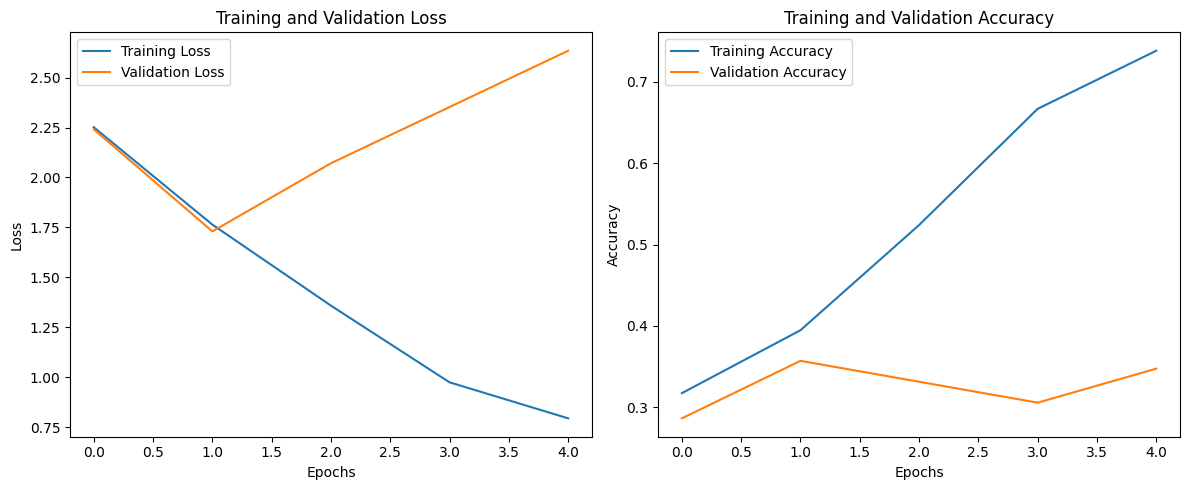

In [65]:
#training and evaluation
#takes extremely long to run on my pc, on the full dataset.
#with visualisation of the accuracies
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

#define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#define a class for early stopping during training
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        
    #method to determine whether to stop training based on the validation score
    def should_stop(self, score):
        if self.best_score is None:
            self.best_score = score
            return False
        elif score > self.best_score + self.min_delta:
            self.best_score = score
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False
            
#function to evaluate loss and accuracy
def evaluate_with_loss(model, dataloader, device):
    
    #initialize variables for calculating loss and accuracy
    correct_predictions = 0
    total_samples = 0
    running_loss = 0.0
    
    #set the model to evaluation mode
    model.eval()
    #disable gradient calculation
    with torch.no_grad():
        #iterate over the data loader
        for img1, img2, img3, img4, img5, labels in dataloader:
            #move data to the device
            img1 = img1.to(device)
            img2 = img2.to(device)
            img3 = img3.to(device)
            img4 = img4.to(device)
            img5 = img5.to(device)
            labels = labels.to(device).long()  #ensure labels are of type Long
            
            #forward pass through the model
            outputs = model(img1, img2, img3, img4, img5)
            #calculate the loss
            loss = criterion(outputs, labels)
            #calculate the number of correct predictions
            running_loss += loss.item() * img1.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            #update the total number of samples
            total_samples += labels.size(0)
            
    #calculate the average loss
    loss = running_loss / total_samples
    #calculate the accuracy
    accuracy = correct_predictions / total_samples
    return loss, accuracy


#function to train the model
def train_model(model, train_dataloader, val_dataloader, num_epochs, device, early_stopping):
    #move the model to the specified device
    model.to(device)
    #initialize lists to store training and validation losses, and accuracies
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    #iterate over the specified number of epochs
    for epoch in range(num_epochs):
        #set the model to train mode
        model.train()
        #initialize variables for loss and accuracy calculation
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        #iterate over the training data loader
        for img1, img2, img3, img4, img5, labels in train_dataloader:
            #move data to the device
            img1 = img1.to(device)
            img2 = img2.to(device)
            img3 = img3.to(device)
            img4 = img4.to(device)
            img5 = img5.to(device)
            labels = labels.to(device).long()  # Ensure labels are of type Long
            #zero the parameter gradients
            optimizer.zero_grad()
            #forward pass through the model
            outputs = model(img1, img2, img3, img4, img5)
            #compute the loss
            loss = criterion(outputs, labels)
            #backward pass and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * img1.size(0)  # Assuming all images have the same batch size
            #compute the number of correct predictions
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            #update the total number of samples
            total_samples += labels.size(0)
        
        #calculate the average loss and accuracy for the epoch
        epoch_loss = running_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        #evaluate on the validation set
        val_loss, val_accuracy = evaluate_with_loss(model, val_dataloader, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        #print epoch-wise training and validation metrics
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
        
        #check for early stopping based on validation accuracy
        if early_stopping.should_stop(val_accuracy):
            print("Early stopping triggered")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies


#number of epochs had to be kept at a relatively low value, otherwise it took too long, with a low value for patience too.
num_epochs = 10
patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#my machine does not have the cuda available, is just for demonstration purposes
early_stopping = EarlyStopping(patience=patience)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, num_epochs, device, early_stopping)

#evaluate the model on the test dataset
test_loss, test_accuracy = evaluate_with_loss(model, test_dataloader, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


#plot the training and validation loss

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()